<a href="https://colab.research.google.com/github/arteagac/xlogit/blob/master/examples/convert_data_wide_to_long.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convert Data from Wide to Long Format

`xlogit` processes data only in long format. However, converting data from wide to long format is a relatively easy task and `xlogit` provides a convinient tool for this purpose. In this tutorial, we'll explain the reshaping using two examples. Let's start by importing the `pandas` and `numpy` python packages.

In [1]:
import pandas as pd
import numpy as np

In case you haven't installed `xlogit`, you can install it using `pip` as follows:

In [2]:
!pip install xlogit

## Basic example

This example provides a quick intuition about the format conversion using `pandas`.

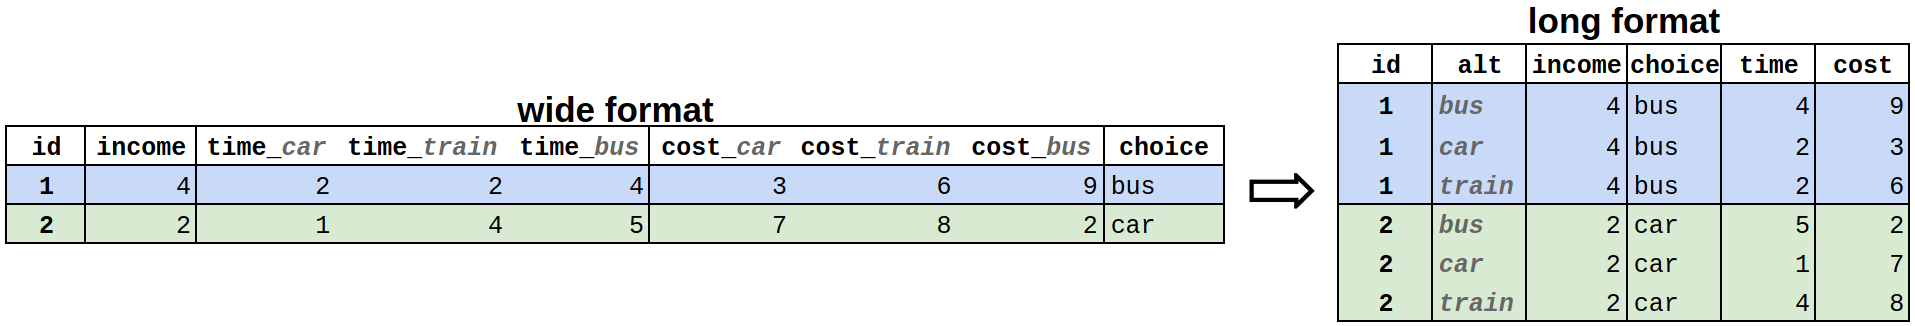

Let's create some artificial data in wide format for our example. Let's assume that our dataset contains choices among three transportation modes (i.e. car, train, and bus)  for two individuals identified by `id`. We assume we collected the income of the individuals, and the time and cost of the transportation modes and saved the data in the `df_wide` dataframe as follows:

In [3]:
# Create example dataset in wide format
df_wide = pd.DataFrame({'id': [1, 2],
                        'income': [4, 2],
                        'time_car': [2, 1],
                        'time_train': [2, 4],
                        'time_bus': [4, 5],
                        'cost_car': [3, 7],
                        'cost_train': [6, 8],
                        'cost_bus': [9, 2],
                        'choice': ['bus', 'car']
                        })
df_wide

,id,income,time_car,time_train,time_bus,cost_car,cost_train,cost_bus,choice
0,1,4,2,2,4,3,6,9,bus
1,2,2,1,4,5,7,8,2,car


The dataframe `df_wide` is in wide format because every row represent a sample in the dataset. The variables `time` and `cost` have one column for each choice alternative, as these as alternative-specific variables. After parsing these data to long format, we want the alternative-specific variables to be in rows and not in columns; therefore, in long format every row is associated with an alternative.

To convert `df_wide` to long format we use the `wide_to_long` function provided by `xlogit`.

In [4]:
from xlogit.utils import wide_to_long
df_long = wide_to_long(df_wide, id_col='id', alt_list=['car', 'train', 'bus'],
                       varying=['time', 'cost'], alt_name='alt', sep='_')

df_long

,id,alt,time,cost,income,choice
0,1,bus,4,9,4,bus
1,1,car,2,3,4,bus
2,1,train,2,6,4,bus
3,2,bus,5,2,2,car
4,2,car,1,7,2,car
5,2,train,4,8,2,car


In the long format shown above, every three rows represent an individual and every row represents an alternative. An additional column called `alt` was created to indicate the alternative associated to a row, and now the variables `time` and `cost` have their values in different rows insted of columns.  The rest of the variables (i.e. `id`, `choice`, and `income`) are simply repeated across rows as they are associated to the same individual. For instance, the individual with `id` equal to `1` has an `income` of `4`, which is repeated throughout the rows of this individual. This data in long format can be now processed by `xlogit`.

The `wide_to_long` function takes as input the following parameters:
- `dataframe`: The wide-format DataFrame.
- `id_col` : Name of the column that uniquely identifies each sample.
- `alt_list`: List of alternatives.
- `alt_name`: Name of the alternatives column in returned dataset.
- `varying`: List of column names that vary across alternatives.
- `sep`: Separator of column names that vary across alternatives.
- `alt_is_prefix`: True if alternative is prefix of the variable name or False if it is suffix.
- `empty_val`: Value to fill when alternative not available for a certain variable.

The current version of `xlogit` only supports wide to long conversion for `Pandas` dataframes. For additional details about this function, consult the documentation at: https://xlogit.readthedocs.io/en/latest/api/utils.html#xlogit.utils.wide_to_long

## Admissions dataset

This is a dataset used in a binary logit example in [UCLA IDRE's website](https://stats.idre.ucla.edu/stata/dae/logistic-regression/). The idea is to predict model the admission to a program based on the candidate's gre, gpa and school's rank. The outcome variable is `admit`, which is equal to 1 when the student was admited or zero otherwise. Note that we added an `id` column to uniquely identify each row.
> Note that this dataset does not contain alternative-specific variables. All the explanatory variables are individual specific.

In [5]:
import pandas as pd

df_wide = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/binary.dta")
df_wide['id'] = np.arange(len(df_wide))  # Add unique identifier column
df_wide

,admit,gre,gpa,rank,id
0,0.0,380.0,3.61,3.0,0
1,1.0,660.0,3.67,3.0,1
2,1.0,800.0,4.00,1.0,2
3,1.0,640.0,3.19,4.0,3
4,0.0,520.0,2.93,4.0,4
...,...,...,...,...,...
395,0.0,620.0,4.00,2.0,395
396,0.0,560.0,3.04,3.0,396
397,0.0,460.0,2.63,2.0,397
398,0.0,700.0,3.65,2.0,398


Now we can proceed to convert the data to long format as follows:

In [6]:
df = wide_to_long(df_wide, id_col='id', alt_list=[0, 1], alt_name='alt')
df

,id,alt,admit,gre,gpa,rank
0,0,0,0.0,380.0,3.61,3.0
1,0,1,0.0,380.0,3.61,3.0
2,1,0,1.0,660.0,3.67,3.0
3,1,1,1.0,660.0,3.67,3.0
4,2,0,1.0,800.0,4.00,1.0
...,...,...,...,...,...,...
795,397,1,0.0,460.0,2.63,2.0
796,398,0,0.0,700.0,3.65,2.0
797,398,1,0.0,700.0,3.65,2.0
798,399,0,0.0,600.0,3.89,3.0


Before fitting the model, let's create dummy representations of the `rank` variable to include them in the model.

In [7]:
df['rank'] = df['rank'].astype(int)  # Convert to int first for better column naming
df = df.join(pd.get_dummies(df['rank'], prefix='rank'))
df

,id,alt,admit,gre,gpa,rank,rank_1,rank_2,rank_3,rank_4
0,0,0,0.0,380.0,3.61,3,0,0,1,0
1,0,1,0.0,380.0,3.61,3,0,0,1,0
2,1,0,1.0,660.0,3.67,3,0,0,1,0
3,1,1,1.0,660.0,3.67,3,0,0,1,0
4,2,0,1.0,800.0,4.00,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
795,397,1,0.0,460.0,2.63,2,0,1,0,0
796,398,0,0.0,700.0,3.65,2,0,1,0,0
797,398,1,0.0,700.0,3.65,2,0,1,0,0
798,399,0,0.0,600.0,3.89,3,0,0,1,0


Now we can use these data in `xlogit`, as shown below. Note that the base category for `rank`, called `rank_1`, was not included in the model.

In [8]:
from xlogit import MultinomialLogit

model = MultinomialLogit()
varnames = ['gpa', 'gre', 'rank_2', 'rank_3', 'rank_4']
model.fit(X=df[varnames],
          y=df['admit'],
          varnames=varnames,
          isvars=varnames,
          ids=df['id'],
          alts=df['alt'],
          fit_intercept=True)
model.summary()

Estimation time= 0.0 seconds
---------------------------------------------------------------------------
Coefficient              Estimate      Std.Err.         z-val         P>|z|
---------------------------------------------------------------------------
_intercept.1           -3.9901156     1.0668058    -3.7402454       0.00081 ***
gpa.1                   0.8040565     0.2998838     2.6812267        0.0224 *  
gre.1                   0.0022645     0.0009793     2.3124578        0.0556 .  
rank_2.1               -0.6754427     0.3038699    -2.2228022         0.068 .  
rank_3.1               -1.3402258     0.3329743    -4.0250129      0.000278 ***
rank_4.1               -1.5514728     0.4055016    -3.8260580      0.000591 ***
---------------------------------------------------------------------------
Significance:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Log-Likelihood= -229.259
AIC= 470.517
BIC= 494.466


Note that the estimation results are identical to those displayed in the [original example in UCLA IDRE's website](https://stats.idre.ucla.edu/stata/dae/logistic-regression/).
The `.1` suffix for the coefficient names represents the alternative that they are associated with. Given that in this case it is a binary logit, the coefficients are interpreted as being relative to the base alternative `0`.